# Quantitative Portfolio Optimization in Python

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from scipy.stats import norm

import pyfolio as pf

import createEFPortfolio as efp

In [3]:
dfPrice = pd.read_excel(r'.\data\price.xlsx', parse_dates=['DATE'])
dfPrice.set_index(['DATE'], inplace=True)

dfTickers = pd.read_excel(r'.\data\tickers.xlsx')
dfTickers = dfTickers[dfTickers.enable == 1]
tickers = dfTickers.ticker.tolist()
lb = dfTickers.lb.values.reshape(-1, 1)
ub = dfTickers.ub.values.reshape(-1, 1)

resample_rule = 'W-FRI'
modelName = 'neural.h5'

df = dfPrice[tickers]
#print(df.info())

### i. Efficient Frontier Portfolio with PyPortfolioOpt
pip install PyPortfolioOpt

In [4]:
efp.create_xl_EFPortfolio(df, lb, ub, resample_rule)

#0 error:{'start': Timestamp('2004-04-30 00:00:00'), 'end': Timestamp('2004-05-07 00:00:00')}'>' not supported between instances of 'NoneType' and 'float'
#16 error:{'start': Timestamp('2004-08-20 00:00:00'), 'end': Timestamp('2004-08-27 00:00:00')}'>' not supported between instances of 'NoneType' and 'float'
#48 error:{'start': Timestamp('2005-04-01 00:00:00'), 'end': Timestamp('2005-04-08 00:00:00')}'>' not supported between instances of 'NoneType' and 'float'
#326 error:{'start': Timestamp('2010-07-30 00:00:00'), 'end': Timestamp('2010-08-06 00:00:00')}'>' not supported between instances of 'NoneType' and 'float'
[====================] 100%

### ii. Training Model with Keras

In [5]:
dfWeightsEF = pd.read_excel(r"weightsEF.xlsx")
dfWeightsEF.set_index(['epochs'], inplace=True)
dfReturnsEF = pd.read_excel(r"returnsEF.xlsx")
dfReturnsEF.set_index(['epochs'], inplace=True)

#print(dfWeightsEF.info())

In [6]:
efp.create_model(dfReturnsEF, dfWeightsEF, modelName)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 572 samples, validate on 246 samples
Epoch 1/1000
572/572 [==============================] - 1s 932us/step - loss: 0.0070 - acc: 0.0455 - val_loss: 0.0042 - val_acc: 0.0691
Epoch 2/1000
572/572 [==============================] - 0s 207us/step - loss: 0.0032 - acc: 0.1381 - val_loss: 0.0027 - val_acc: 0.1992
Epoch 3/1000
572/572 [==============================] - 0s 286us/step - loss: 0.0023 - acc: 0.1906 - val_loss: 0.0025 - val_acc: 0.1301
Epoch 4/1000
572/572 [==============================] - 0s 291us/step - loss: 0.0019 - acc: 0.2185 - val_loss: 0.0020 - val_acc: 0.2154
Epoch 5/1000
572/572 [==============================] - 0s 210us/step - loss: 0.0017 - acc: 0.2535 - val_loss: 0.0021 - val_acc: 0.1301
Epoch 6/1000
572/572 [==============================] - 0s 151us/step - loss: 0.0016 - acc: 0.2657 - val_loss: 0.0018 - val_acc: 0.1951
Epoch 7/1000
572/572 [================

### iii. Predicting

In [7]:
dfWeightsEF = pd.read_excel(r"weightsEF.xlsx")
dfWeightsEF.set_index(['epochs'], inplace=True)
dfReturnsEF = pd.read_excel(r"returnsEF.xlsx")
dfReturnsEF.set_index(['epochs'], inplace=True)

#print(dfWeightsEF.info())

In [8]:
dfReturns = dfPrice[tickers + ['R_FREE']]
dfReturns = dfReturns.pct_change().dropna()

dfRetW = dfReturns[tickers].resample(resample_rule).mean()

model = load_model(modelName)
model_predict = model.predict(dfRetW)

In [9]:
dfWeights = pd.DataFrame(data=model_predict,  columns=tickers, index = dfRetW.index.tolist())
dfWeights['RFREE'] = 1 - dfWeights.sum(axis=1)

dfWeights = dfWeights.resample('D').ffill()
dfWeights.index.names = ['DATE']

dfWeights = dfWeights.loc[dfWeights.index.isin(dfReturns.index.tolist())]
dfReturns = dfReturns.loc[dfReturns.index.isin(dfWeights.index.tolist())]

retFund = (dfWeights.values * dfReturns.values).sum(axis=1)

dfFUND = pd.DataFrame(data=(1 + retFund).cumprod(),  index=dfWeights.index.to_list())
dfFUND.columns = ["NAV"]
dfFUND.index.names = ['DATE']

dfFUND['RET'] = dfFUND.NAV.pct_change()
dfFUND['VOL126'] = dfFUND.RET.rolling(126).std() * 252 ** 0.5
dfFUND['VOL252'] = dfFUND.RET.rolling(252).std() * 252 ** 0.5

dfFUND = pd.concat([dfWeights, dfFUND], axis=1)

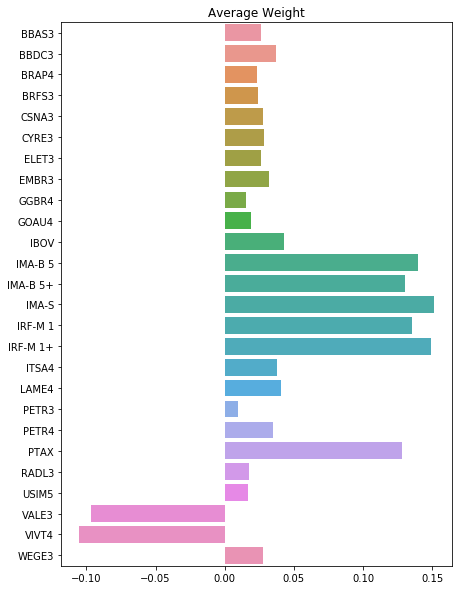

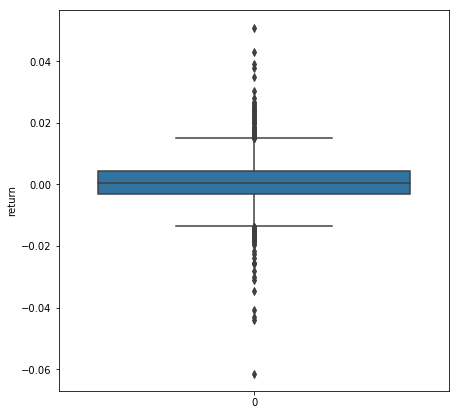

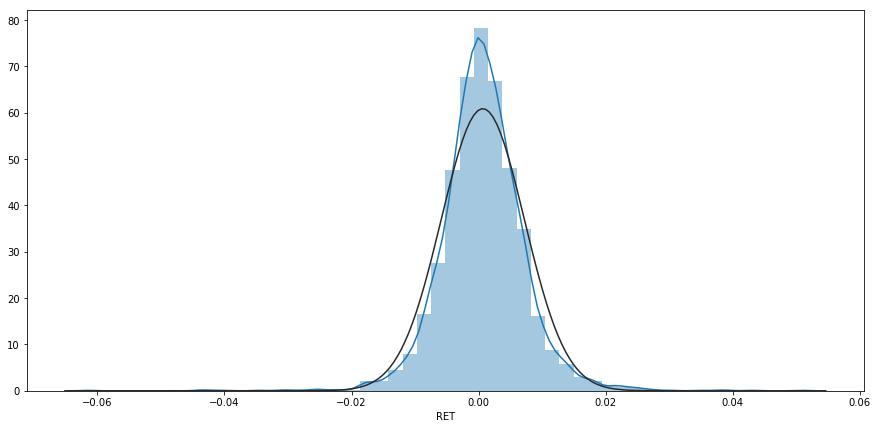

In [10]:
plt.figure(figsize = (7,10))
#ax = sns.barplot(x="val", y="index", hue="variable", data=dfPortMaxSharpe)
ax = sns.barplot(dfFUND[tickers].mean().values, dfFUND[tickers].mean().index)
_ = plt.title('Average Weight')


plt.figure(figsize = (7,7))
ax = sns.boxplot(data=dfFUND.RET.dropna())
_ = ax.set(ylabel='return')

plt.figure(figsize = (15,7))
ax = sns.distplot(dfFUND.RET.dropna(), fit=norm)

In [11]:
dfFUND.to_excel(r"model_PredictFUND.xlsx")

### iv. Backtesting with Pyfolio
pip install pyfolio


In [12]:
dfNAV = pd.read_excel('model_PredictFUND.xlsx', parse_dates=['DATE'])
dfNAV.set_index(['DATE'], inplace=True)
dfNAV = dfNAV[['NAV']]

dfP = pd.concat([dfNAV, dfPrice[tickers + ['R_FREE']] ], axis=1).dropna()
dfRetALL = dfP.pct_change().dropna()#[-4 * 252::]
dfVolALL = dfRetALL.rolling(252).std().dropna() * 252 ** 0.5
dfALL = (1 + dfRetALL).cumprod().dropna()

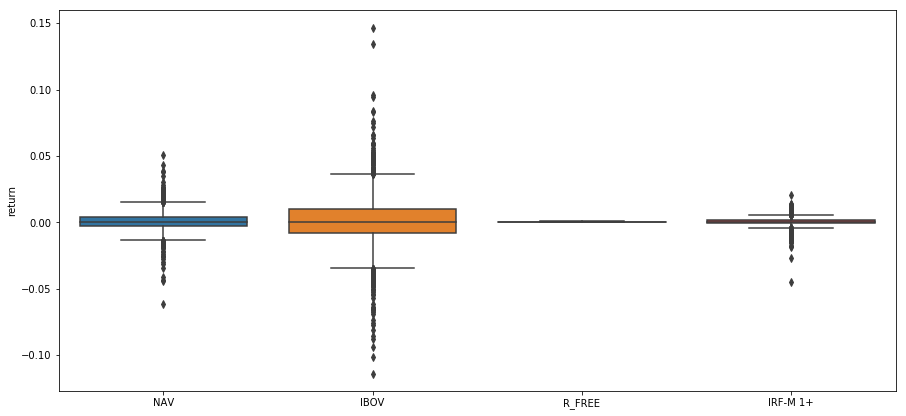

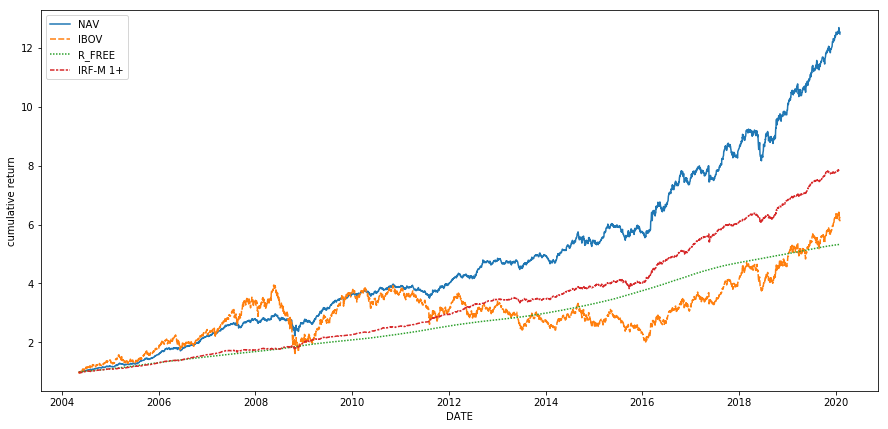

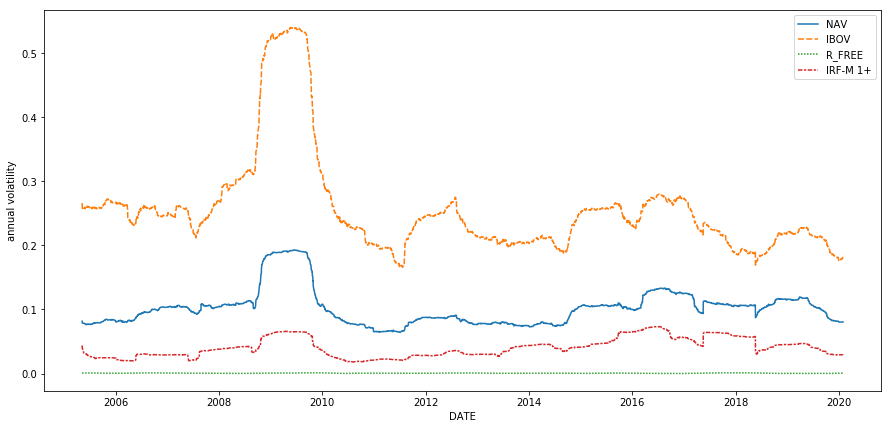

In [14]:
sublist = ['NAV','IBOV','R_FREE','IRF-M 1+']

plt.figure(figsize = (15,7))
ax = sns.boxplot(data=dfRetALL[sublist])
_ = ax.set(ylabel='return')

plt.figure(figsize = (15,7))
ax = sns.lineplot(data = dfALL[sublist])
_ = ax.set(ylabel='cumulative return')

plt.figure(figsize = (15,7))
ax = sns.lineplot(data = dfVolALL[sublist])
_ = ax.set(ylabel='annual volatility')

Start date,2004-05-10
End date,2020-01-31
Total months,188
,Backtest
Annual return,17.4%
Cumulative returns,1146.2%
Annual volatility,10.4%
Sharpe ratio,1.60
Calmar ratio,0.69
Stability,0.96
Max drawdown,-25.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.15,2008-05-30,2008-10-27,2009-04-29,239
1,11.95,2010-11-08,2011-08-08,2011-12-06,282
2,11.64,2018-03-12,2018-06-18,2018-10-04,149
3,9.38,2015-05-15,2015-08-25,2016-03-04,211
4,8.60,2014-09-02,2014-12-15,2015-03-20,144


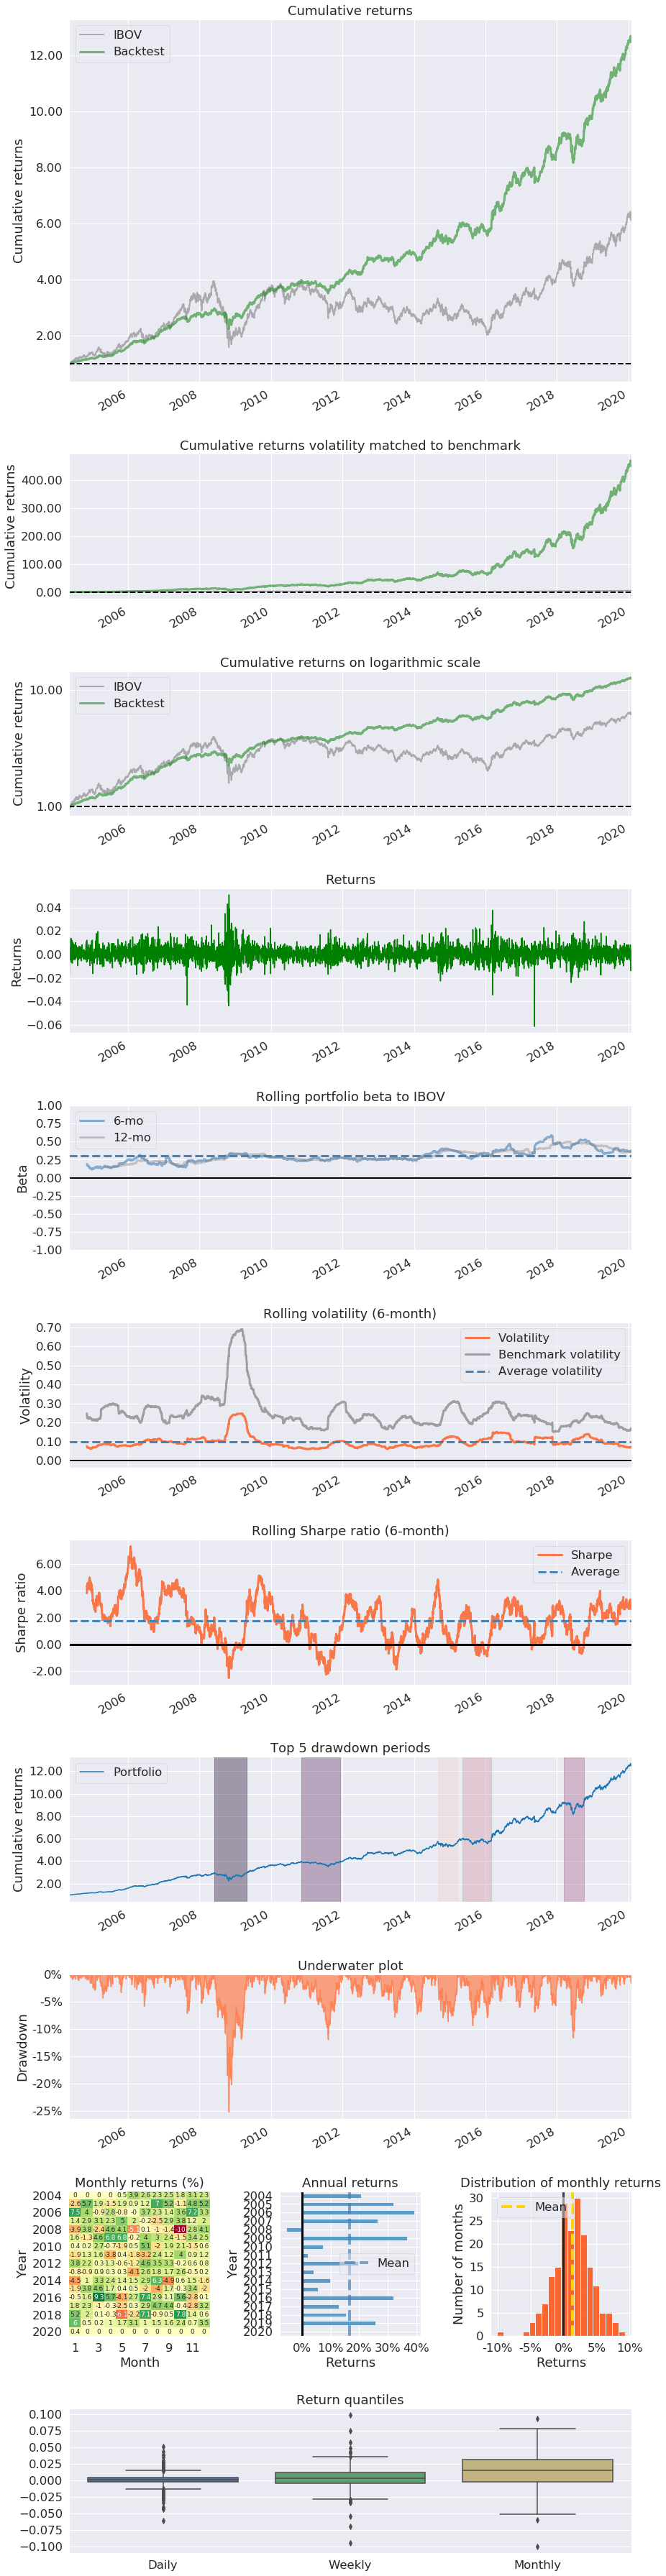

In [16]:
# Create a tear sheet on returns
pf.create_returns_tear_sheet(dfRetALL.NAV.tz_localize('UTC'), 
                             benchmark_rets = dfRetALL.IBOV.tz_localize('UTC'))

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.15,2008-05-30,2008-10-27,2009-04-29,239
1,11.95,2010-11-08,2011-08-08,2011-12-06,282
2,11.64,2018-03-12,2018-06-18,2018-10-04,149
3,9.38,2015-05-15,2015-08-25,2016-03-04,211
4,8.60,2014-09-02,2014-12-15,2015-03-20,144


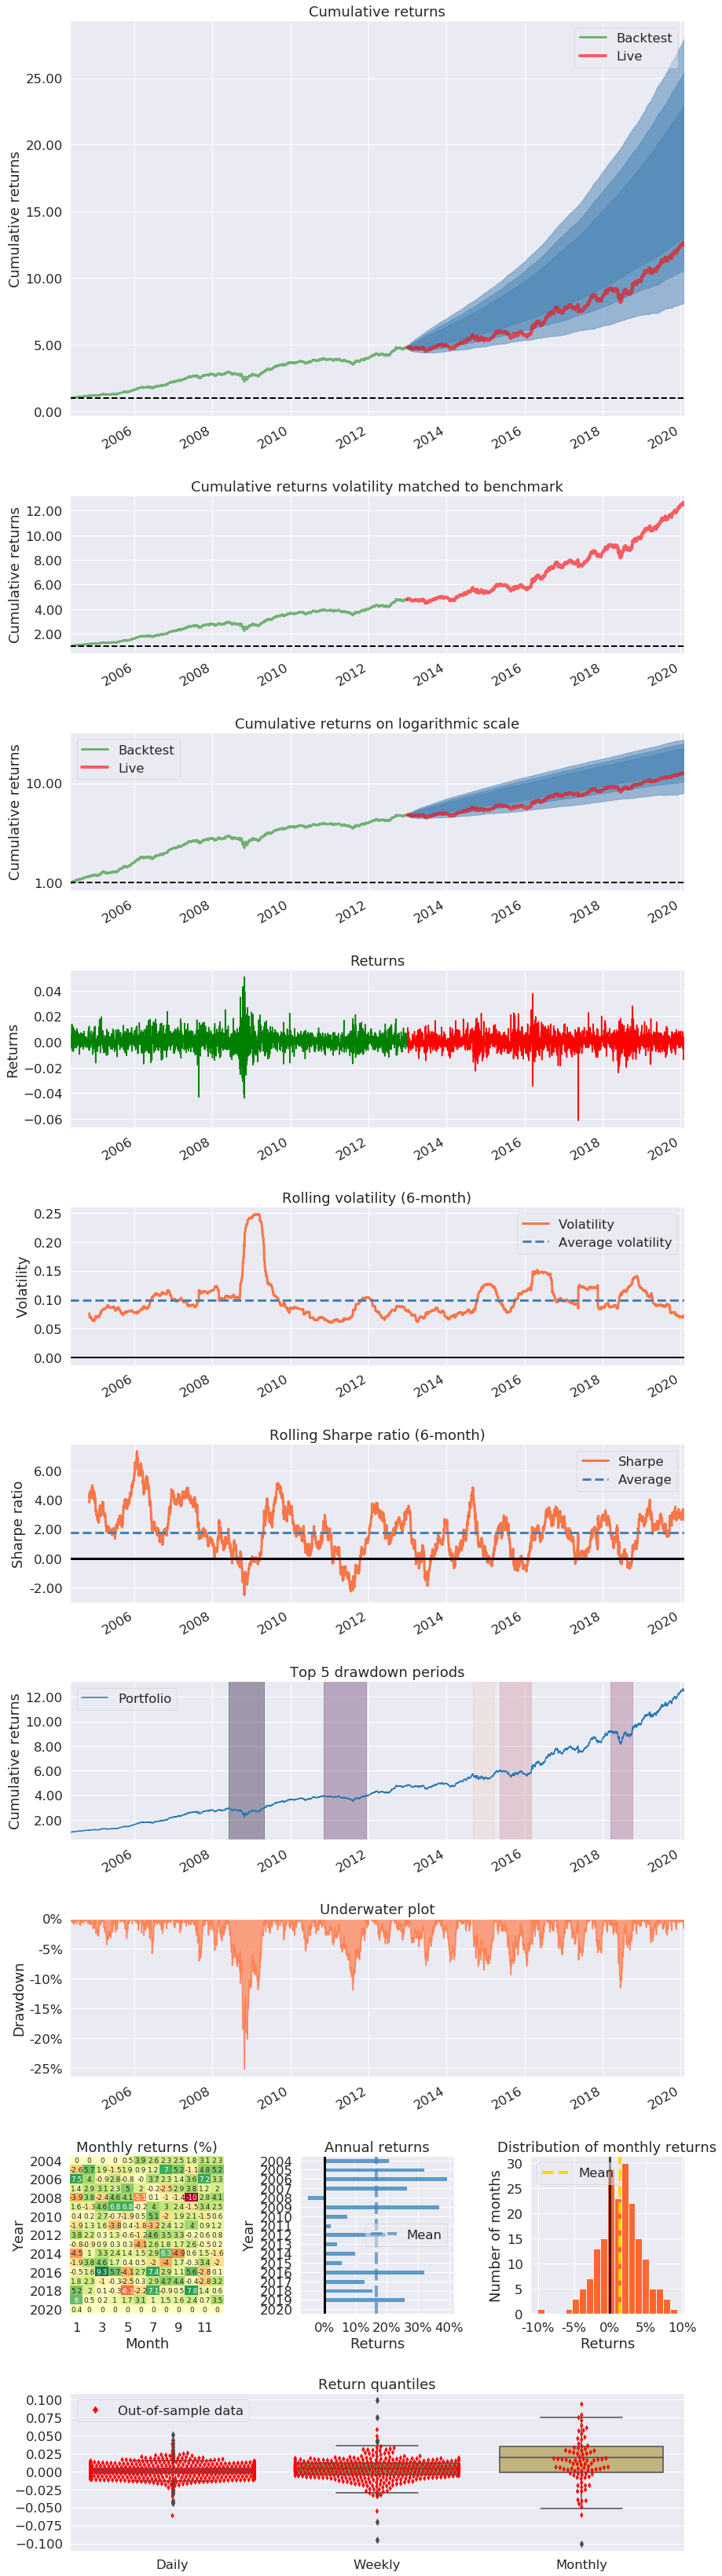

In [17]:
# If you have backtest and live data
pf.create_returns_tear_sheet(dfRetALL.NAV.tz_localize('UTC'), 
                             live_start_date='2012-12-31')